In [55]:
#Import MNIST dataset with torchvision

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import tqdm
from typing import Type
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#import torchvision.transforms as transforms

# Loading the dataset

In [56]:
# Display mnist image with a tensor as an input
def show_image(img):
    npimg = img.squeeze(0).numpy()
    plt.imshow(np.transpose(npimg), cmap = 'grey')#, (1, 2, 0)), interpolation='nearest')

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [5]:
emnist_dataset = torchvision.datasets.EMNIST(root='./data', split='byclass',  download=True, transform=transforms)
emnist_loader = DataLoader(emnist_dataset, batch_size=64, shuffle=True)

In [6]:
#Print label number
print(emnist_dataset[0][1])

35


torch.Size([64, 1, 28, 28])
torch.Size([64])


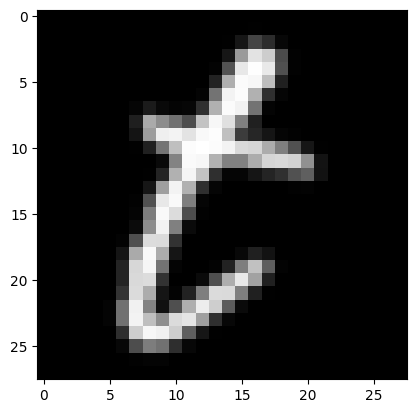

In [7]:
for i, (images, labels) in enumerate(emnist_loader):
    print(images.shape)
    print(labels.shape)
    show_image(images[0])
    break

In [8]:
# Calculate mean and std of the dataset
mean = emnist_dataset.data.float().mean()/255
std = emnist_dataset.data.float().std()/255
print('mean:', mean)
print('std:', std)

mean: tensor(0.1736)
std: tensor(0.3317)


In [9]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std,)),
    torchvision.transforms.RandomCrop(
        size = 28,
        padding = 2,
        padding_mode = 'reflect'
    ),
    torchvision.transforms.RandomRotation(
        degrees = 15
    )
])

In [10]:
emnist_dataset = torchvision.datasets.EMNIST(root='./data', split='byclass',  download=True, transform=transforms)
emnist_loader = DataLoader(emnist_dataset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


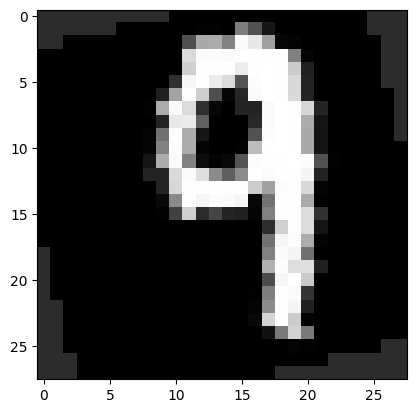

In [11]:
for i, (images, labels) in enumerate(emnist_loader):
    print(images.shape)
    print(labels.shape)
    show_image(images[0])
    break

In [104]:
emnist_trainset = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transforms)
emnist_testset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transforms)

# Implementing ResNet-18

In [58]:
class ResidualBlock(nn.Module):
    def __init__(self, 
                 in_channels : int, 
                 out_channels : int, 
                 stride : int = 1, 
                   ) -> None:
        super(ResidualBlock, self).__init__()
        
          
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 :
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=1, 
                    stride=stride, 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )
        else :
            self.downsample = nn.Identity()

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        
        return out

In [59]:
class ResNet_18(nn.Module):
    def __init__(self,
                 num_classes : int = 62, 
                 ResidualBlock : Type[nn.Module] = ResidualBlock
                 ) -> None :
        super(ResNet_18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.num_classes = num_classes

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1
        )

        # Residual layers
        self.layer1 = nn.Sequential(
            ResidualBlock(
                in_channels = 64, 
                out_channels = 64,
                stride = 1,),
            ResidualBlock(
                in_channels = 64, 
                out_channels = 64,
                stride = 1,)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(
                in_channels = 64, 
                out_channels = 128,
                stride = 2, ),
            ResidualBlock(
                in_channels = 128, 
                out_channels = 128,
                stride = 1,)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(
                in_channels = 128, 
                out_channels = 256,
                stride = 2, ),
            ResidualBlock(
                in_channels = 256, 
                out_channels = 256,
                stride = 1,)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(
                in_channels = 256, 
                out_channels = 512,
                stride = 2, ),
            ResidualBlock(
                in_channels = 512, 
                out_channels = 512,
                stride = 1,)
        )

        self.adaptative_pool = nn.AdaptiveAvgPool2d((1,1))

        self.classify1 = nn.Linear(512, 256)
        self.classify2 = nn.Linear(256, self.num_classes)

    def forward(self, x : torch.Tensor()) -> torch.Tensor :
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #for classification 
        x = self.adaptative_pool(x)
        x = torch.flatten(x, 1)
        x = self.classify1(x)
        x = self.classify2(x)
        return x

## The simple CNN model


In [15]:
class MNIST_classifier(nn.Module):
    def __init__(self):
        super(MNIST_classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride = 2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride = 2, padding=1)
        #self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride = 3)
        
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(576, 10)

        self.fc2 = nn.Linear(256, 10)

        

        self.max_pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.max_pool(F.relu(self.conv2(x))))
        x = self.conv_drop(x)
        #print(x.shape)
        x = x.view(-1, 576)
    
        #print(x.shape)
        x = self.fc1(x)
        #x = F.dropout(x, training=self.training)
        #x = F.relu(x)
        return x
    

    #FOR MAC 


## Simple Linear Model

In [16]:
"""
 inputs = Input(shape=(784,))
  x = Dense(256, activation='relu')(inputs)
  x = Dense(128, activation='relu')(x)
  outputs = Dense(len(LABELS), activation='softmax')(x)

"""

class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 47)

    def forward(self, x):
        x=torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.softmax(self.linear3(x))
        return x

# Training

In [62]:
device = torch.device('mps')

In [68]:
def train(model, train_loader, optimizer, epoch, critetion, acc_dict, loss_dict) :
    model.train()
    total_loss = 0 
    total_acc = 0
    with tqdm.tqdm(range(len(train_loader))) as pbar:
        
        for X,Y in train_loader:
            plt.imshow(X[0].squeeze(0).cpu())
            X,Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            output = model(X)#.to(device)
            

            loss = critetion(output, Y)
            pred = output.argmax(dim=1, keepdim=True)
            #print(X.shape ,output.shape, Y.shape, pred.shape)
            #print((pred.squeeze(0) == Y).sum())
            #pred = np.array(pred.item().cpu())
            #Y = np.array(Y.unsqueeze(0).cpu())
            correct = pred.eq(Y.view_as(pred)).sum().item()
            total_acc += correct/len(X)
            #print(pred, Y)

            #print((pred.squeeze(0) == Y).sum().item()/len(X))
            total_loss += loss.item()
            loss.backward()

            optimizer.step()    
            pbar.update(1)
    
    acc_dict[epoch] = [total_acc/len(train_loader)*100]
    loss_dict[epoch] = [total_loss/len(train_loader)]
    print(f'[TRAIN] : For epoch {epoch}, the loss is {total_loss/len(train_loader)} and the accuracy is {total_acc/len(train_loader)*100}')

In [67]:
def test(model, test_loader , epoch, criterion, best_loss, acc_dict, loss_dict):
    model.eval()
    with torch.no_grad():
        total_acc = 0 
        total_loss = 0 
        with tqdm.tqdm(range(len(test_loader))) as pbar:
            for X,Y in test_loader : 
                X,Y = X.to(device), Y.to(device)
                
                output = model(X)#.to(device)

                loss = criterion(output, Y)
                pred = output.argmax(dim=1, keepdim=True)

                correct = pred.eq(Y.view_as(pred)).sum().item()
                #total_loss += loss.item()
                total_acc += correct/len(X)
                total_loss += loss.item()
                pbar.update(1)

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    torch.save(model.state_dict(), 'model/ResNet-18/only_letters/resnet.pth')

        acc_dict[epoch].append(total_acc/len(test_loader)*100)
        loss_dict[epoch].append(total_loss/len(test_loader))
        print(f'[TEST] : For epoch {epoch}, the loss is {total_loss/len(test_loader)} and the accuracy is {total_acc*100/len(test_loader)}')

        return best_loss


In [94]:
train_loader = DataLoader(emnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(emnist_testset, batch_size=256, shuffle=True)

#model = SimpleLinearModel().to(device)
model = ResNet_18(num_classes=len(emnist_testset.classes)).to(device)
#model = MNIST_classifier().to(device)

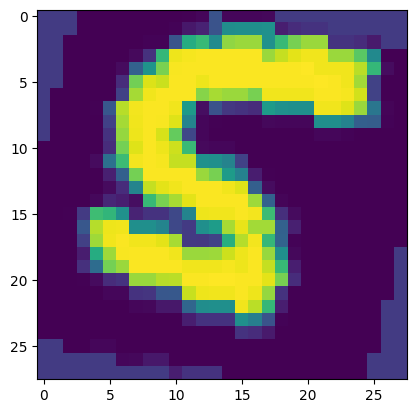

Label is : 5


In [64]:
import random
X,Y = emnist_loader.dataset[random.randint(0, len(emnist_loader.dataset))]
#transpose the image
X = X.transpose(1,2)
plt.imshow(X[0].squeeze(0).cpu())
plt.show()
print(f'Label is : {emnist_loader.dataset.classes[Y]}')

## Only using letters EMNIST


  0%|          | 0/488 [00:00<?, ?it/s]

100%|██████████| 488/488 [00:51<00:00,  9.42it/s]


[TRAIN] : For epoch 0, the loss is 1.329973893026348 and the accuracy is 62.060546875


100%|██████████| 82/82 [00:06<00:00, 12.00it/s]


[TEST] : For epoch 0, the loss is 0.40304984315866377 and the accuracy is 87.06173780487805


100%|██████████| 488/488 [00:53<00:00,  9.20it/s]


[TRAIN] : For epoch 1, the loss is 0.3248962198429909 and the accuracy is 89.25941342213115


100%|██████████| 82/82 [00:06<00:00, 12.44it/s]


[TEST] : For epoch 1, the loss is 0.3322344624051234 and the accuracy is 88.64329268292683


100%|██████████| 488/488 [00:53<00:00,  9.05it/s]


[TRAIN] : For epoch 2, the loss is 0.2702766597026684 and the accuracy is 90.98600794057377


100%|██████████| 82/82 [00:06<00:00, 12.45it/s]


[TEST] : For epoch 2, the loss is 0.3469649811343449 and the accuracy is 88.71474847560975


100%|██████████| 488/488 [00:52<00:00,  9.24it/s]


[TRAIN] : For epoch 3, the loss is 0.24898877171952216 and the accuracy is 91.69121413934425


100%|██████████| 82/82 [00:06<00:00, 11.97it/s]


[TEST] : For epoch 3, the loss is 0.261532394260895 and the accuracy is 91.53963414634147


100%|██████████| 488/488 [00:52<00:00,  9.22it/s]


[TRAIN] : For epoch 4, the loss is 0.23613562795226692 and the accuracy is 92.11785988729508


100%|██████████| 82/82 [00:06<00:00, 12.59it/s]


[TEST] : For epoch 4, the loss is 0.2687582934229839 and the accuracy is 91.5015243902439


100%|██████████| 488/488 [00:53<00:00,  9.20it/s]


[TRAIN] : For epoch 5, the loss is 0.16356300477121696 and the accuracy is 94.34634349385246


100%|██████████| 82/82 [00:06<00:00, 12.47it/s]


[TEST] : For epoch 5, the loss is 0.16958521897109544 and the accuracy is 94.22160823170732


100%|██████████| 488/488 [00:53<00:00,  9.19it/s]


[TRAIN] : For epoch 6, the loss is 0.14812398831680662 and the accuracy is 94.78579661885246


100%|██████████| 82/82 [00:06<00:00, 12.42it/s]


[TEST] : For epoch 6, the loss is 0.16395361040060114 and the accuracy is 94.36928353658537


100%|██████████| 488/488 [00:53<00:00,  9.11it/s]


[TRAIN] : For epoch 7, the loss is 0.14299384434325774 and the accuracy is 94.8578381147541


100%|██████████| 82/82 [00:06<00:00, 11.97it/s]


[TEST] : For epoch 7, the loss is 0.1620109673680329 and the accuracy is 94.4455030487805


100%|██████████| 488/488 [00:53<00:00,  9.20it/s]


[TRAIN] : For epoch 8, the loss is 0.1391542957576572 and the accuracy is 95.00912525614754


100%|██████████| 82/82 [00:06<00:00, 12.31it/s]


[TEST] : For epoch 8, the loss is 0.1628147946988664 and the accuracy is 94.3454649390244


100%|██████████| 488/488 [00:52<00:00,  9.23it/s]


[TRAIN] : For epoch 9, the loss is 0.1362366635871471 and the accuracy is 95.06275614754098


100%|██████████| 82/82 [00:06<00:00, 12.48it/s]


[TEST] : For epoch 9, the loss is 0.16078240487997125 and the accuracy is 94.54554115853658


100%|██████████| 488/488 [00:53<00:00,  9.19it/s]


[TRAIN] : For epoch 10, the loss is 0.12601610499083019 and the accuracy is 95.34852074795081


100%|██████████| 82/82 [00:06<00:00, 12.32it/s]


[TEST] : For epoch 10, the loss is 0.15369669039074968 and the accuracy is 94.67892530487805


100%|██████████| 488/488 [00:52<00:00,  9.26it/s]


[TRAIN] : For epoch 11, the loss is 0.12394730891024724 and the accuracy is 95.46778944672131


100%|██████████| 82/82 [00:06<00:00, 12.37it/s]


[TEST] : For epoch 11, the loss is 0.15185438691661124 and the accuracy is 94.84089176829268


100%|██████████| 488/488 [00:52<00:00,  9.26it/s]


[TRAIN] : For epoch 12, the loss is 0.12292972791054455 and the accuracy is 95.47659451844262


100%|██████████| 82/82 [00:06<00:00, 12.51it/s]


[TEST] : For epoch 12, the loss is 0.14986878815220622 and the accuracy is 94.65034298780488


100%|██████████| 488/488 [00:53<00:00,  9.19it/s]


[TRAIN] : For epoch 13, the loss is 0.12166247805427821 and the accuracy is 95.49420466188525


100%|██████████| 82/82 [00:06<00:00, 12.43it/s]


[TEST] : For epoch 13, the loss is 0.15265528503351095 and the accuracy is 94.68845274390245


100%|██████████| 488/488 [00:52<00:00,  9.23it/s]


[TRAIN] : For epoch 14, the loss is 0.1195492526348375 and the accuracy is 95.53262679303278


100%|██████████| 82/82 [00:06<00:00, 12.44it/s]


[TEST] : For epoch 14, the loss is 0.1542353837228403 and the accuracy is 94.65510670731707


100%|██████████| 488/488 [00:52<00:00,  9.25it/s]


[TRAIN] : For epoch 15, the loss is 0.11991874864477603 and the accuracy is 95.49100281762296


100%|██████████| 82/82 [00:06<00:00, 12.55it/s]


[TEST] : For epoch 15, the loss is 0.1520556191482195 and the accuracy is 94.75514481707317


100%|██████████| 488/488 [00:52<00:00,  9.23it/s]


[TRAIN] : For epoch 16, the loss is 0.1179554052192901 and the accuracy is 95.57985399590164


100%|██████████| 82/82 [00:06<00:00, 12.50it/s]


[TEST] : For epoch 16, the loss is 0.14915981298176254 and the accuracy is 94.74085365853658


100%|██████████| 488/488 [00:52<00:00,  9.28it/s]


[TRAIN] : For epoch 17, the loss is 0.11861099563081001 and the accuracy is 95.62307889344262


100%|██████████| 82/82 [00:06<00:00, 12.63it/s]


[TEST] : For epoch 17, the loss is 0.14865501352199695 and the accuracy is 94.75514481707317


100%|██████████| 488/488 [00:53<00:00,  9.20it/s]


[TRAIN] : For epoch 18, the loss is 0.11845246194022112 and the accuracy is 95.55343878073771


100%|██████████| 82/82 [00:06<00:00, 12.54it/s]


[TEST] : For epoch 18, the loss is 0.15290204635480556 and the accuracy is 94.67416158536585


100%|██████████| 488/488 [00:52<00:00,  9.21it/s]


[TRAIN] : For epoch 19, the loss is 0.1170479625341345 and the accuracy is 95.63828765368852


100%|██████████| 82/82 [00:06<00:00, 12.45it/s]


[TEST] : For epoch 19, the loss is 0.14727492612309573 and the accuracy is 94.90282012195122


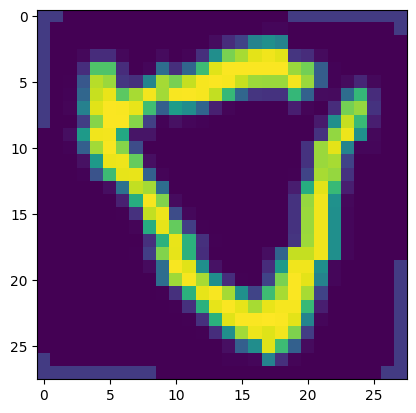

In [69]:
acc_dict = {}
loss_dict = {}
criterion = F.cross_entropy
optimizer = torch.optim.AdamW(model.parameters(), lr=10e-3)#.to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs = 20
best_loss = 1000
for epoch in range(epochs) : 
    train(model, train_loader, optimizer, epoch, criterion, acc_dict, loss_dict)
    best_loss = test(model, test_loader, epoch, criterion, best_loss, acc_dict, loss_dict)
    scheduler.step()

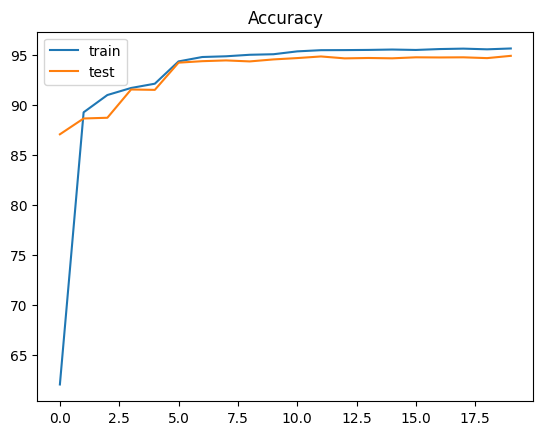

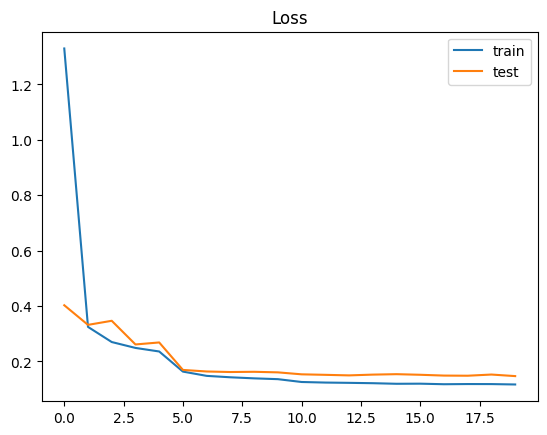

In [70]:
#Plot curves for train and test loss and accuracy train and test
import matplotlib.pyplot as plt

plt.plot(list(acc_dict.keys()), [acc_dict[i][0] for i in acc_dict.keys()], label='train')
plt.plot(list(acc_dict.keys()), [acc_dict[i][1] for i in acc_dict.keys()], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(list(loss_dict.keys()), [loss_dict[i][0] for i in loss_dict.keys()], label='train')
plt.plot(list(loss_dict.keys()), [loss_dict[i][1] for i in loss_dict.keys()], label='test')
plt.title('Loss')
plt.legend()
plt.show()



# Test model

## For letters and digits

In [97]:
model = ResNet_18().to(device)
model.load_state_dict(torch.load('model/ResNet-18/letters_and_digits/resnet.pth'))

<All keys matched successfully>

In [99]:
#display Confusion matrix
model.eval()


y_pred = []
y_true = []
with torch.no_grad():
    for X,Y in test_loader : 
        X,Y = X.to(device), Y.to(device)
        output = model(X).to(device)
        pred = output.argmax(dim=1, keepdim=True)
        y_pred.append(pred)
        y_true.append(Y)
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)



## Confusion Matrix [with byclass EMNIST]

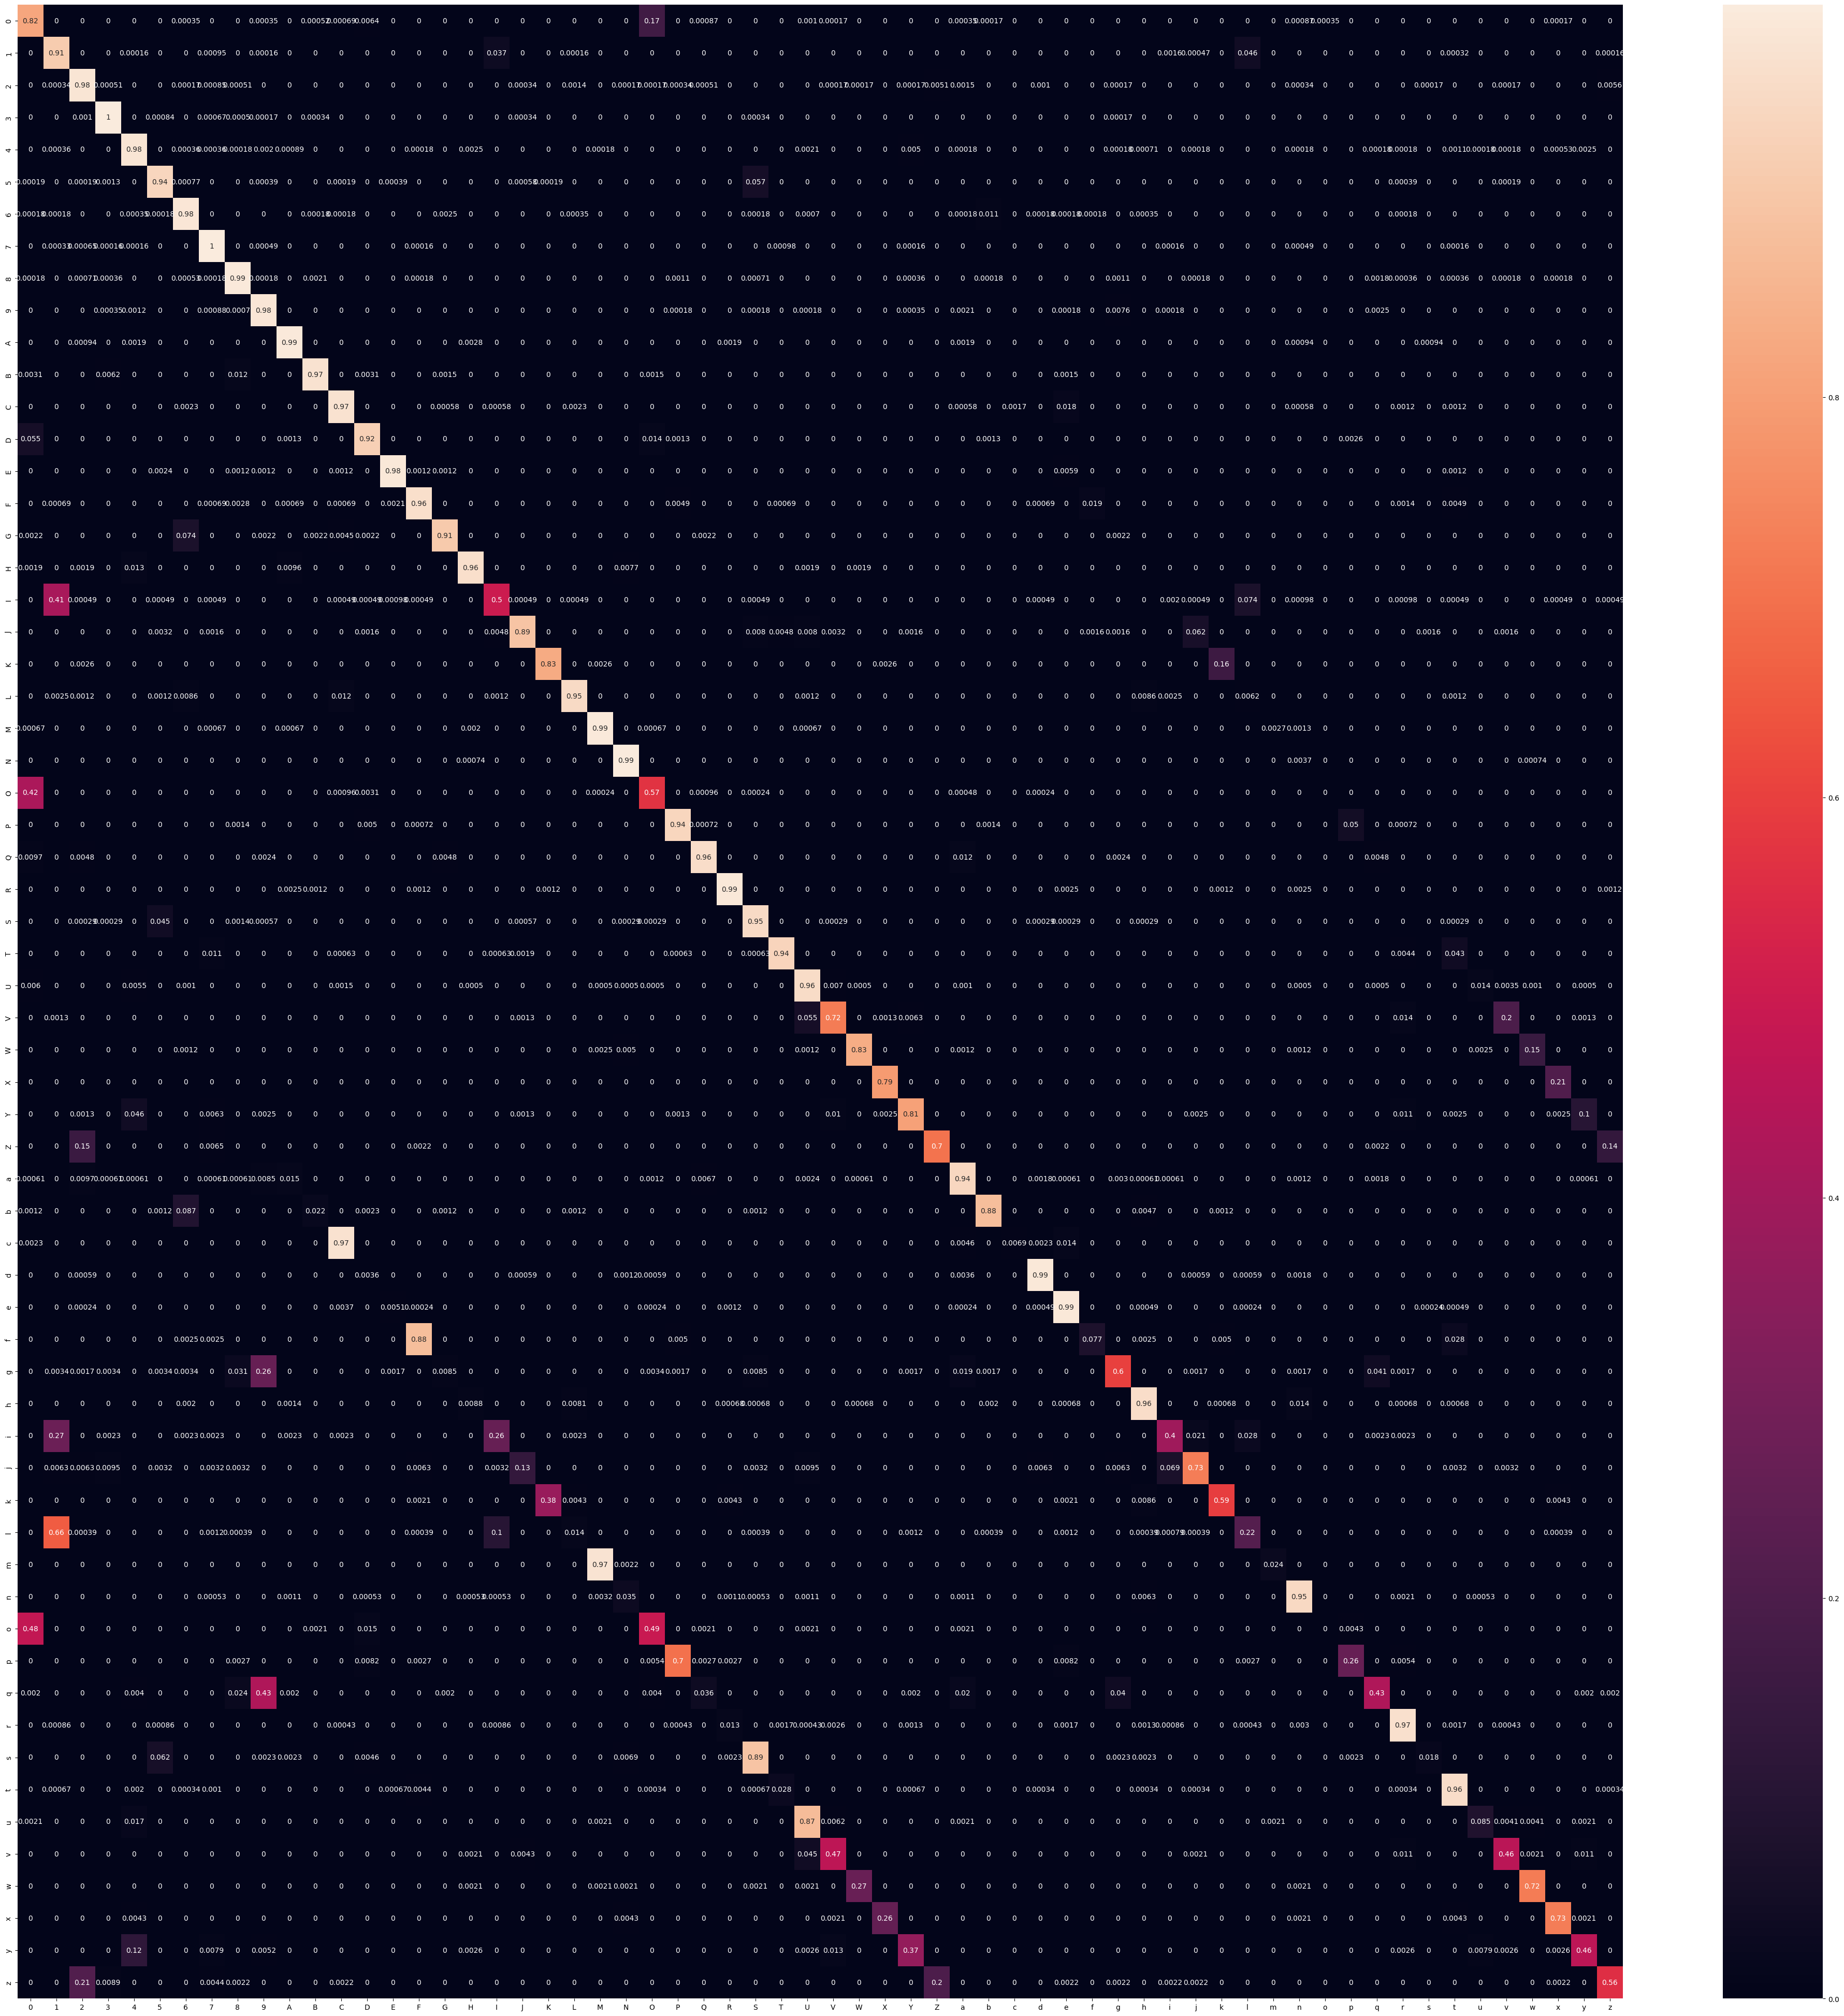

In [101]:
#display Confusion matrix

cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [emnist_testset.classes[i] for i in range(62)], columns = [emnist_testset.classes[i]  for i in range(62)])
plt.figure(figsize = (50,50))
sns.heatmap(df_cm, annot=True)#, cmap='Blues')
plt.show()


Problem is that o is never predicted 

## For only letters

In [78]:
model = ResNet_18(num_classes=len(emnist_testset.classes)).to(device)
model.load_state_dict(torch.load('model/ResNet-18/only_letters/resnet.pth'))

<All keys matched successfully>

In [79]:
#display Confusion matrix
model.eval()


y_pred = []
y_true = []
with torch.no_grad():
    for X,Y in test_loader : 
        X,Y = X.to(device), Y.to(device)
        output = model(X).to(device)
        pred = output.argmax(dim=1, keepdim=True)
        y_pred.append(pred)
        y_true.append(Y)
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)



## Confusion Matrix [with letters EMNIST]

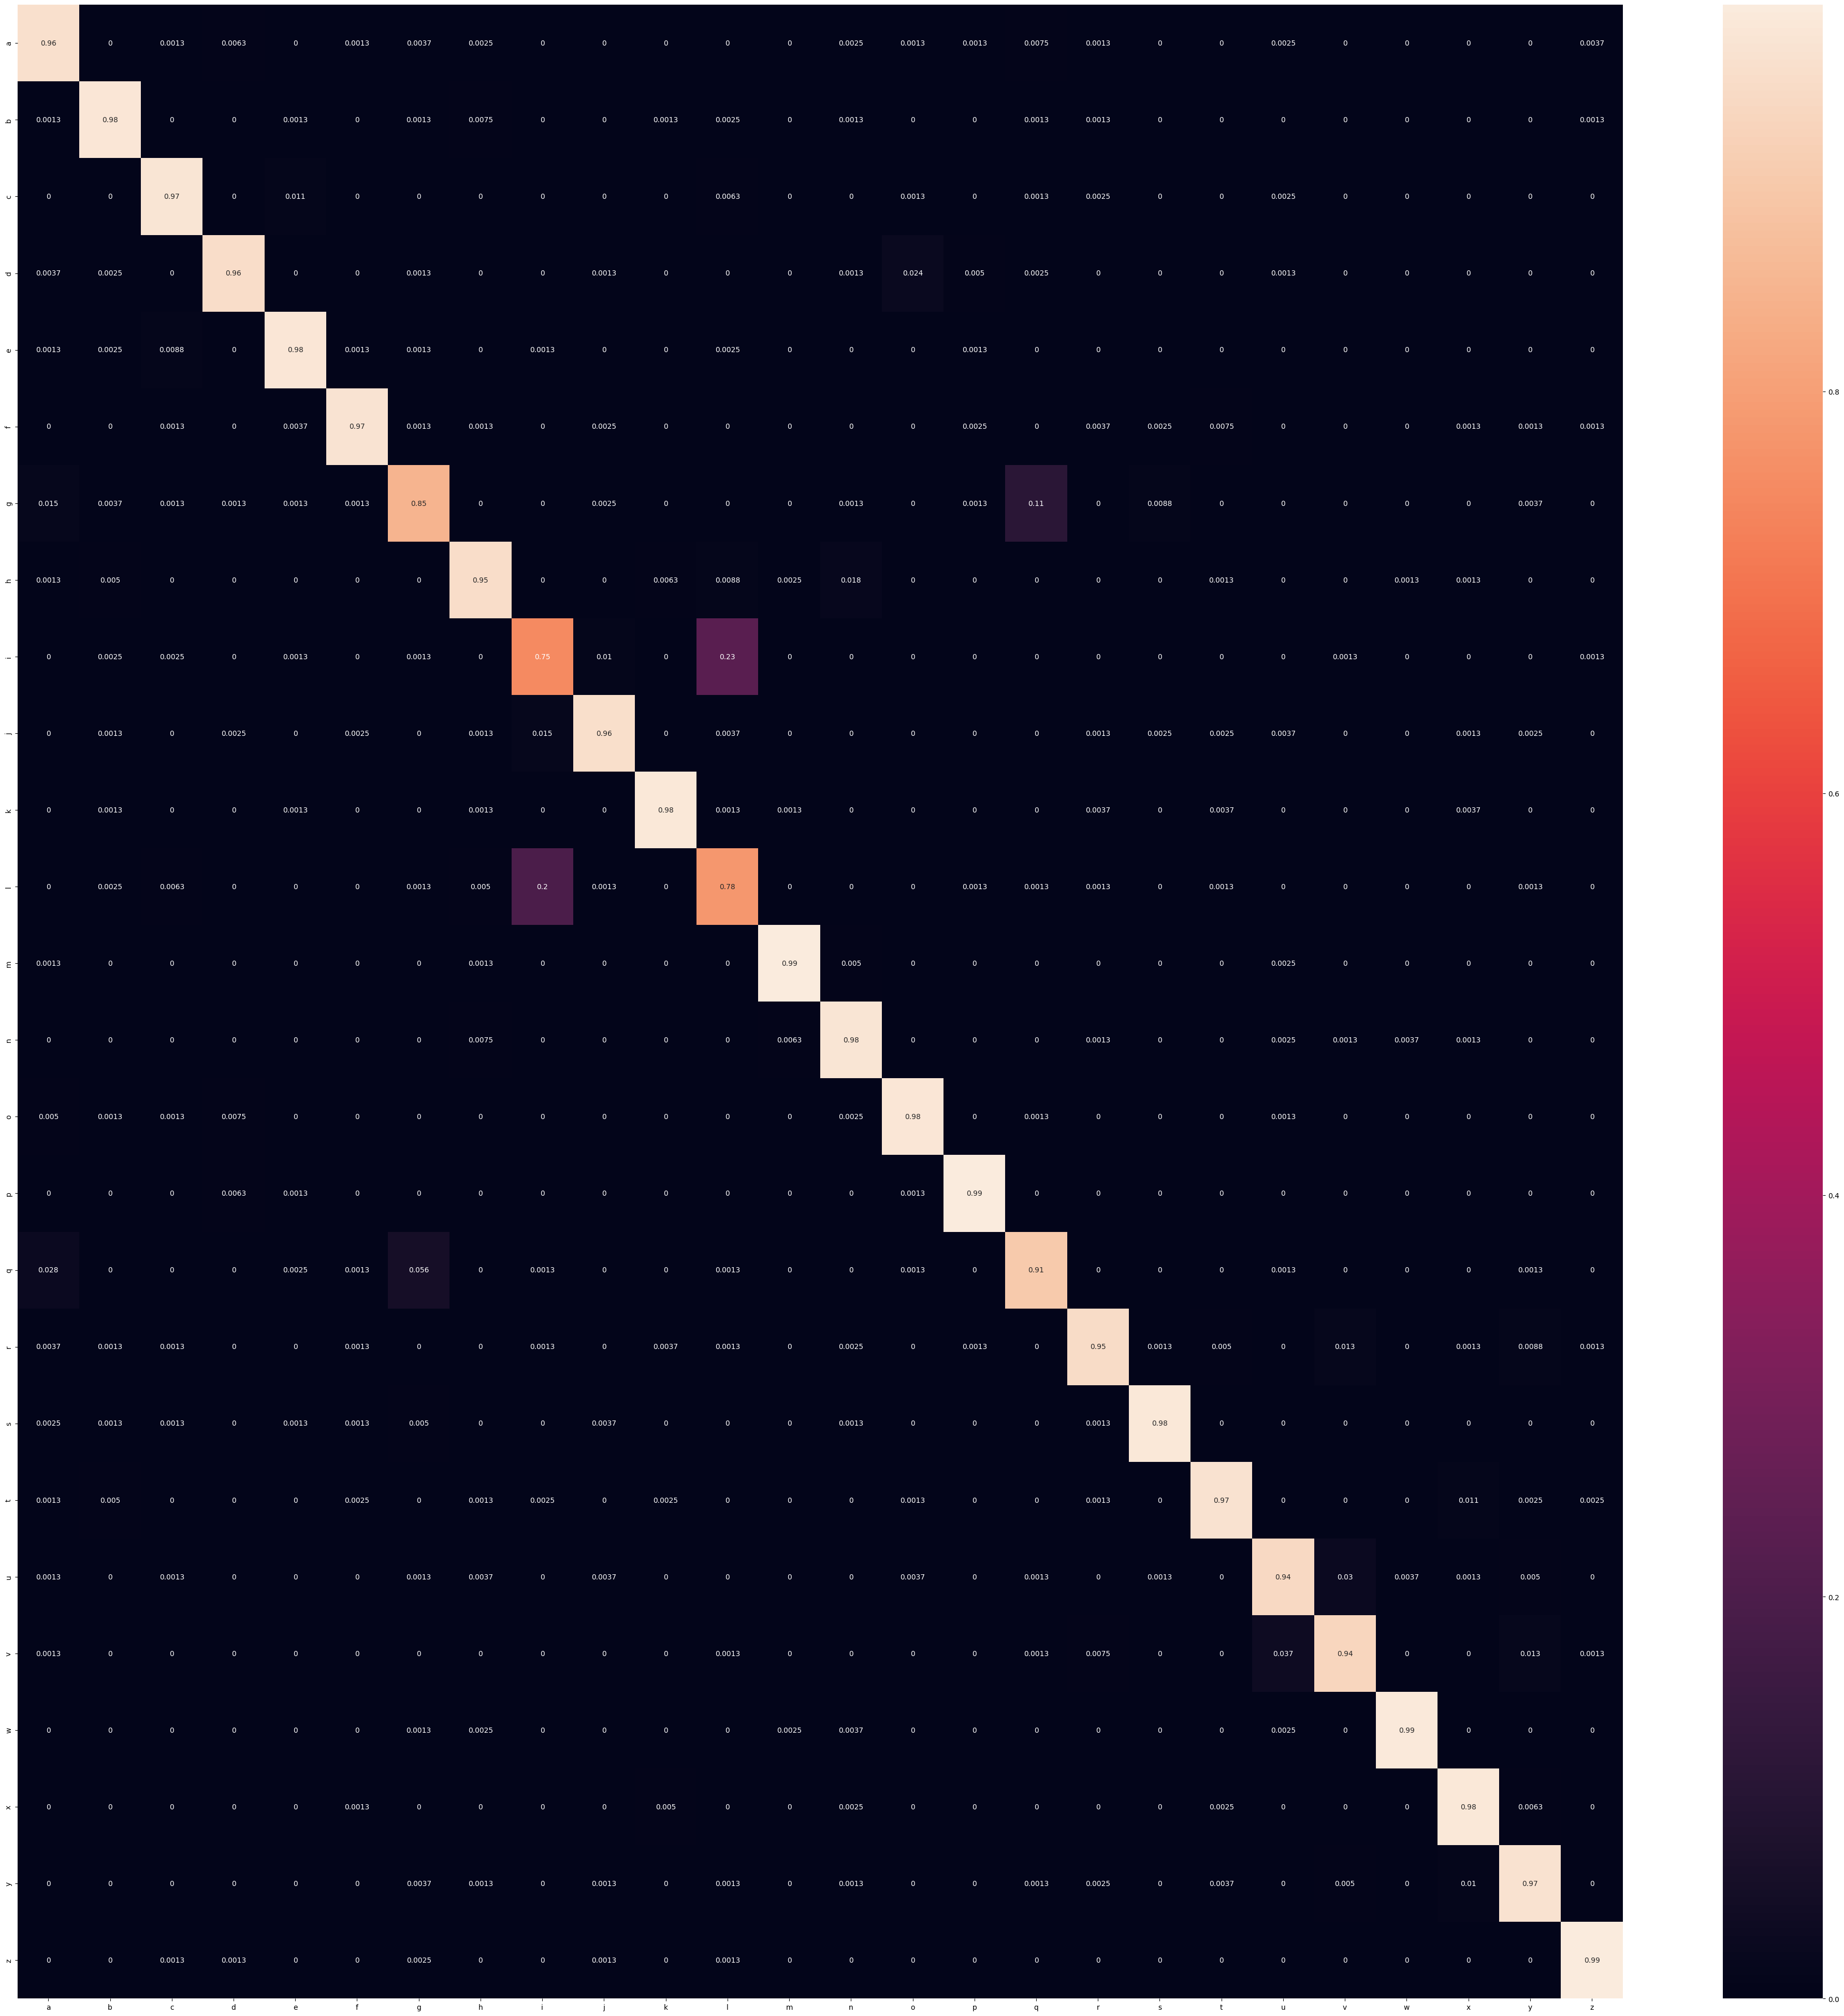

In [88]:
#display Confusion matrix

cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [emnist_testset.classes[i] for i in range(1,len(emnist_testset.classes))], columns = [emnist_testset.classes[i]  for i in range(1,len(emnist_testset.classes))])
plt.figure(figsize = (50,50))
sns.heatmap(df_cm, annot=True)#, cmap='Blues')
plt.show()


### Convert the model to Onnx

In [105]:
#Load best model and convert it to onnx
import onnx 
model = ResNet_18(num_classes=len(emnist_testset.classes))#.to(device)
model.load_state_dict(torch.load('model/ResNet-18/only_letters/resnet.pth'))
model.eval()

dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(model, dummy_input, "model/ResNet-18/only_letters/resnet.onnx", verbose=True, input_names=['input'], output_names=['output'], opset_version=9)


Exported graph: graph(%input : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %classify1.weight : Float(256, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %classify1.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %classify2.weight : Float(27, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %classify2.bias : Float(27, strides=[1], requires_grad=1, device=cpu),
      %onnx::Conv_196 : Float(64, 1, 7, 7, strides=[49, 49, 7, 1], requires_grad=0, device=cpu),
      %onnx::Conv_197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_205 : Float(64, 

### Test the ONNX model 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Prediction : 5 and label is : 5


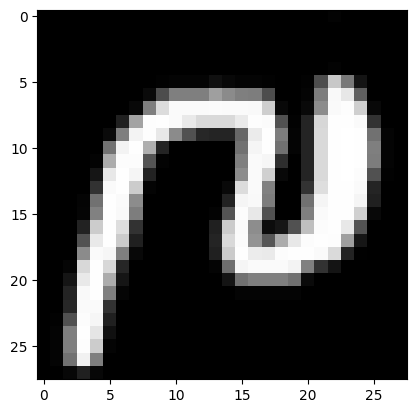

In [19]:
#Take a random image in the test set and display the prediction
import random
import matplotlib.pyplot as plt

model = ResNet_18()#.to(device)
model.load_state_dict(torch.load('model/ResNet-18/best_model.pth'))
model.eval()

#DISPLAY IMAGE


random_index = random.randint(0, len(emnist_testset))

image, label = emnist_testset[random_index]

image = image.unsqueeze(0)
plt.imshow(image.squeeze(0).squeeze(0), cmap='gray')
#transpose the image
#image = image.transpose(2, 3)
plt.imshow(image.squeeze(0).squeeze(0), cmap='gray')
output = model(image)
pred = output.argmax(dim=1, keepdim=True)
print(emnist_testset.classes)
print(f'Prediction : {emnist_testset.classes[pred.item()]} and label is : {emnist_testset.classes[label]}')

### Test onnx model on a random sample

In [20]:
import onnx
import onnxruntime as ort 


model_path = "model/ResNet-18/best_model.onnx"
session = ort.InferenceSession(model_path)
#print(onnx.helper.printable_graph(model.graph))



In [21]:
print(len(emnist_loader.dataset.classes))

62


### Trying to load some images from the web app

[[-0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449]
 [-0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449]
 [-0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449 -0.52336449
  -0.52336

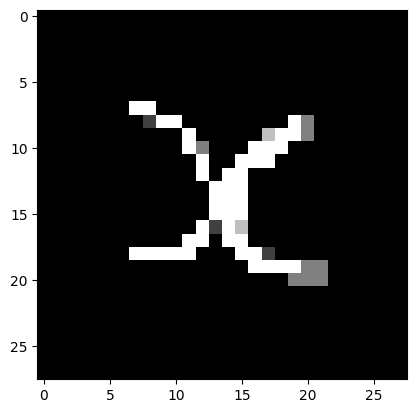

In [54]:
#Load 28x28 image into a tensor
import cv2

img = cv2.imread('x.png', cv2.IMREAD_GRAYSCALE)


plt.imshow(img, cmap='gray')

#Resize the image to get (1,1,28,28) np array 
#Transpose the 28x28 img
img = np.transpose(img)

img = img/255
mean = 0.1736
std = 0.3317
img = (img - mean)/std
print(img)
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
#Convert to float
img = img.astype(np.float32)
print(img.shape)

outputs = session.run(None, {'input': img})

print(f'Prediction is : {emnist_loader.dataset.classes[np.argmax(outputs[0])]}')

(1, 1, 28, 28)
[[[[-0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645 ]
   [-0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645 ]
   [-0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645   0.9781104  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.5233645  -0.5233645  -0.5233645  -0.5233645
    -0.5233645  -0.52

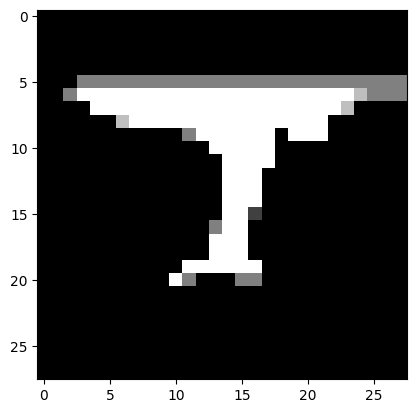

In [51]:
#Load 28x28 image into a tensor
import cv2

img = cv2.imread('processed_image.png', cv2.IMREAD_GRAYSCALE)


plt.imshow(img, cmap='gray')

#Resize the image to get (1,1,28,28) np array 
#Transpose the 28x28 img
img = np.transpose(img)
#Divide by 255
img = img/255
#And substract mean and divide by std

"""
mean: tensor(0.1736)
std: tensor(0.3317)
"""
mean = 0.1736
std = 0.3317
img = (img - mean)/std
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
#Convert to float
img = img.astype(np.float32)
print(img.shape)
print(img)
outputs = session.run(None, {'input': img})

print(f'Prediction is : {emnist_loader.dataset.classes[np.argmax(outputs[0])]}')

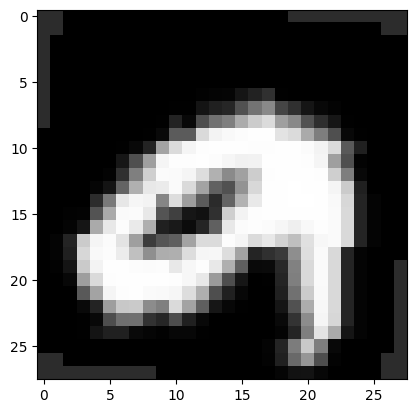

input : [[[[ 0.          0.         -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735  0.
     0.          0.          0.          0.          0.
     0.          0.          0.        ]
   [ 0.          0.         -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735  0.          0.        ]
   [ 0.         -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0.52341735 -0.52341735 -0.52341735
    -0.52341735 -0.52341735 -0

In [44]:
import random
X,Y = emnist_loader.dataset[random.randint(0, len(emnist_loader.dataset))]
#transpose the image
image_for_plotting = X#X.transpose(1,2)
plt.imshow(image_for_plotting[0].squeeze(0).cpu(), cmap = 'gray')
plt.show()
X = X.unsqueeze(0)
X = np.array(X)
#print(X)
outputs = session.run(None, {'input': X})

print(f'input : {X}\nbefore argmax : {outputs[0]}\nAfter argmax : {np.argmax(outputs[0])}')
print(f'Label is : {emnist_loader.dataset.classes[Y]} while prediction is {emnist_loader.dataset.classes[np.argmax(outputs[0])]}')